In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass # to get the password without showing the input
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

password = getpass.getpass()

········


In [2]:
# 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. 
# It should include some film features and some rental features.

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''
SELECT
	f.film_id,
    f.title,
    f.rental_duration,
    f.rental_rate,
    f.length,
    f.rating,
    f.special_features,
    fc.category_id,
    r.rental_date,
    r.staff_id
FROM sakila.film f
JOIN sakila.inventory i using(film_id)
JOIN sakila.film_category fc using(film_id)
JOIN sakila.rental r using(inventory_id)
WHERE Year(r.rental_date) = 2005
;
    '''
# 2. Read the data into a Pandas dataframe.
data = pd.read_sql_query(query,engine)
data.head()

,film_id,title,rental_duration,rental_rate,length,rating,special_features,category_id,rental_date,staff_id
0,19,AMADEUS HOLY,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2005-08-02 01:16:59,2
1,19,AMADEUS HOLY,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2005-08-18 04:26:54,2
2,19,AMADEUS HOLY,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2005-06-20 20:35:28,1
3,19,AMADEUS HOLY,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2005-07-09 05:01:58,2
4,19,AMADEUS HOLY,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2005-07-30 08:02:39,1


In [3]:
# 3. Analyze extracted features and transform them. You may need to encode some categorical variables, 
# or scale numerical variables.
data.isna().sum()

film_id             0
title               0
rental_duration     0
rental_rate         0
length              0
rating              0
special_features    0
category_id         0
rental_date         0
staff_id            0
dtype: int64

In [4]:
data.shape

(15862, 10)

In [5]:
data.dtypes

film_id                      int64
title                       object
rental_duration              int64
rental_rate                float64
length                       int64
rating                      object
special_features            object
category_id                  int64
rental_date         datetime64[ns]
staff_id                     int64
dtype: object

In [6]:
data['film_id'] = data['film_id'].astype('object')
data['category_id'] = data['category_id'].astype('object')
data['staff_id'] = data['staff_id'].astype('object')

In [7]:
data['rental_date'] = data['rental_date'].map(dt.datetime.toordinal)

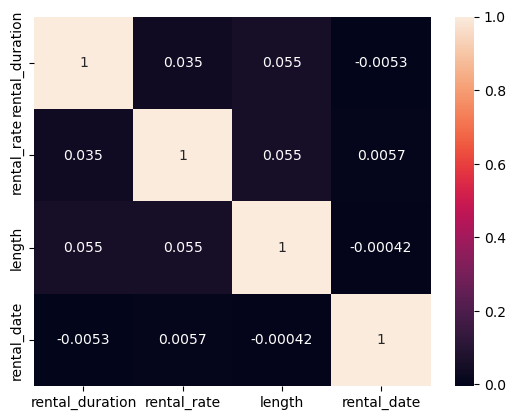

In [8]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

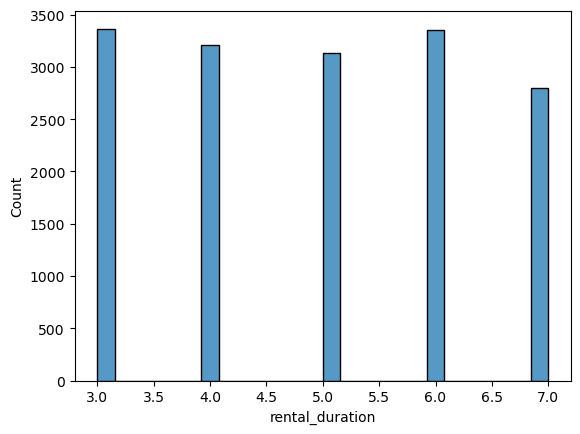

In [9]:
sns.histplot(data['rental_duration'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

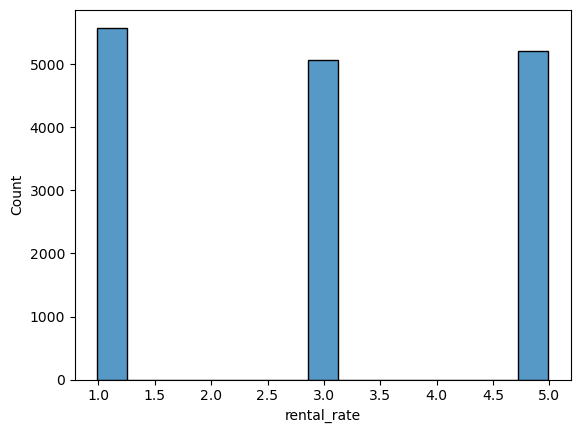

In [10]:
sns.histplot(data['rental_rate'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

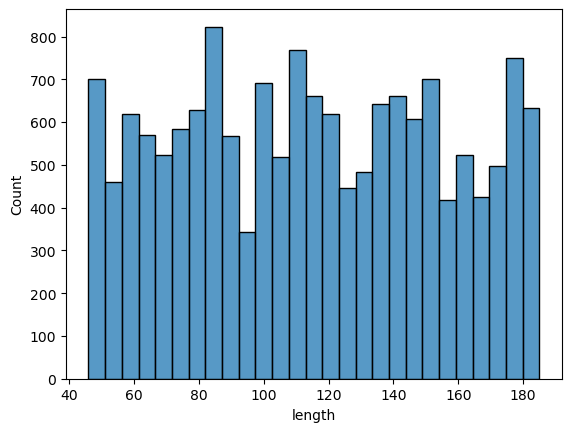

In [11]:
sns.histplot(data['length'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

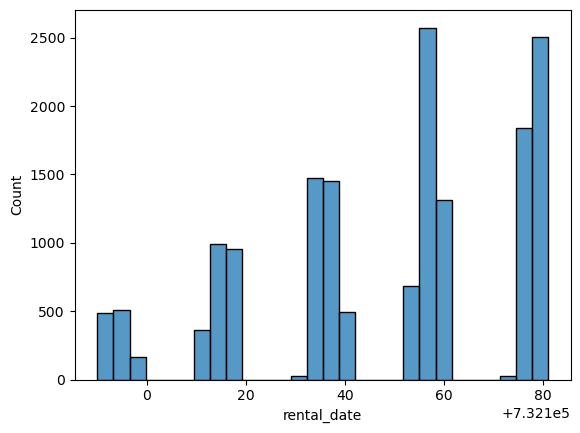

In [12]:
sns.histplot(data['rental_date'])
plt.show

In [13]:
data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')

In [14]:
import numpy as np
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include=np.number)
X.head()

,length,rental_date
0,113,732160
1,113,732176
2,113,732117
3,113,732136
4,113,732157


In [15]:
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)
x.columns = X.columns
x.head()

,length,rental_date
0,0.000154,1.0
1,0.000154,1.0
2,0.000154,1.0
3,0.000154,1.0
4,0.000154,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

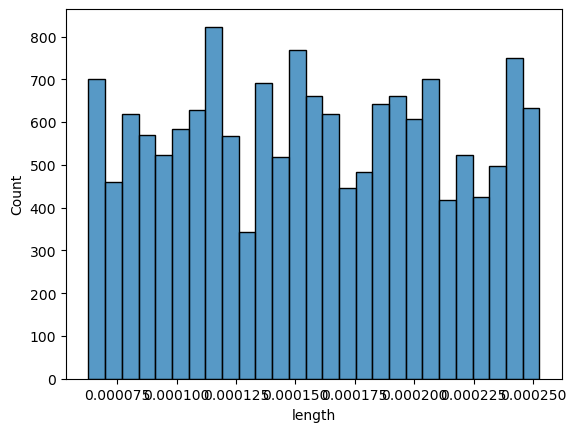

In [16]:
sns.histplot(x['length'])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

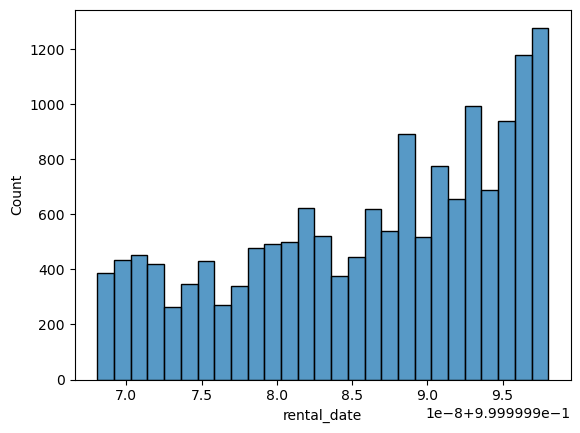

In [17]:
sns.histplot(x['rental_date'])
plt.show

In [18]:
cat = data.select_dtypes(include = object)
cat.drop(['film_id','title'], axis=1, inplace=True)
cat

,rental_duration,rental_rate,rating,special_features,category_id,staff_id
0,6,0.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2
1,6,0.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2
2,6,0.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1
3,6,0.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,2
4,6,0.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1
...,...,...,...,...,...,...
15857,4,4.99,R,"Commentaries,Deleted Scenes",16,1
15858,4,4.99,R,"Commentaries,Deleted Scenes",16,1
15859,4,4.99,R,"Commentaries,Deleted Scenes",16,1
15860,4,4.99,R,"Commentaries,Deleted Scenes",16,1


In [19]:
# split the 'special_features' column by ',' and extract unique values
strings_to_check = cat['special_features'].str.split(',', expand=True).stack().str.strip().unique()

# loop over the list and create new columns
for string in strings_to_check:
    cat[string] = cat['special_features'].str.contains(string).astype(int)

# drop the original column 'special_features'
cat.drop('special_features', axis=1, inplace=True)

cat

,rental_duration,rental_rate,rating,category_id,staff_id,Commentaries,Deleted Scenes,Behind the Scenes,Trailers
0,6,0.99,PG,1,2,1,1,1,0
1,6,0.99,PG,1,2,1,1,1,0
2,6,0.99,PG,1,1,1,1,1,0
3,6,0.99,PG,1,2,1,1,1,0
4,6,0.99,PG,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
15857,4,4.99,R,16,1,1,1,0,0
15858,4,4.99,R,16,1,1,1,0,0
15859,4,4.99,R,16,1,1,1,0,0
15860,4,4.99,R,16,1,1,1,0,0


In [20]:
categorical = pd.get_dummies(cat,columns=
                             ['rental_duration','rental_rate','rating',
                              'category_id','staff_id'])
categorical

C:\Users\pc\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Commentaries,Deleted Scenes,Behind the Scenes,Trailers,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_0.99,...,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16,staff_id_1,staff_id_2
0,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15857,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15858,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15859,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
15860,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [21]:
X = pd.DataFrame(np.concatenate((x,categorical),axis=1))

In [22]:
# 4. Create a query to get the list of films and a boolean indicating if it was rented last month. 
# This would be our target variable.
query = '''
SELECT
	f.film_id,
    f.title,
     case
         when month(r.rental_date) = 8 AND YEAR(r.rental_date) = 2005 
            THEN 'True' 
            ELSE 'False' 
       END AS rented_Aug_2005 
FROM sakila.film f
JOIN sakila.inventory i using(film_id)
JOIN sakila.film_category fc using(film_id)
JOIN sakila.rental r using(inventory_id)
WHERE Year(r.rental_date) = 2005;
    '''
data2 = pd.read_sql_query(query,engine)
data2.head()

,film_id,title,rented_Aug_2005
0,19,AMADEUS HOLY,True
1,19,AMADEUS HOLY,True
2,19,AMADEUS HOLY,False
3,19,AMADEUS HOLY,False
4,19,AMADEUS HOLY,False


In [23]:
y = data2['rented_Aug_2005']
y.head()

0     True
1     True
2    False
3    False
4    False
Name: rented_Aug_2005, dtype: object

In [24]:
y.value_counts()

False    10176
True      5686
Name: rented_Aug_2005, dtype: int64

In [25]:
# 5. Create a logistic regression model to predict this variable from the cleaned data.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4)
classification = LogisticRegression().fit(X_train,y_train)

In [26]:
predictions = classification.predict(X_test)
predictions

array(['False', 'False', 'False', ..., 'False', 'False', 'False'],
      dtype=object)

In [27]:
# 6. Evaluate the results.
classification.score(X_test,y_test)

0.6427107959022853

In [28]:
y_test.value_counts()

False    4078
True     2267
Name: rented_Aug_2005, dtype: int64

In [29]:
pd.DataFrame(predictions).value_counts()

False    6345
dtype: int64

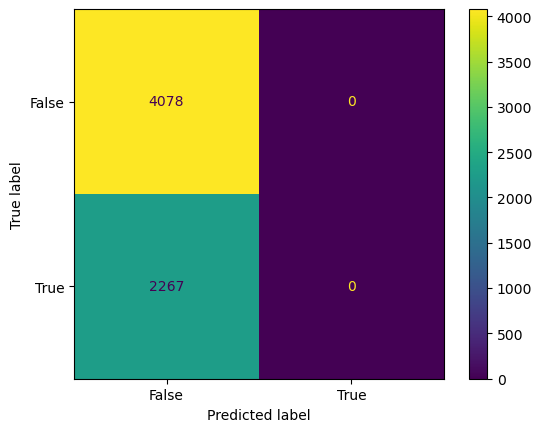

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=classification.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classification.classes_)
disp.plot()

plt.show()

In [32]:
# The model is not predicting any True values, the next step would be to balance the data